In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import mode


In [2]:
# Load and normalize CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# **Use Functional API for CNN Model**
input_layer = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding="same", activation="relu")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
feature_layer = Dense(256, activation="relu")(x)  # Feature Extraction Layer
x = Dropout(0.5)(feature_layer)
output_layer = Dense(10, activation="softmax")(x)


In [3]:
# Create Model
cnn_model = Model(inputs=input_layer, outputs=output_layer)

# Training callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2)

# Compile model
cnn_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train model
history = cnn_model.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 253ms/step - accuracy: 0.3580 - loss: 1.9164 - val_accuracy: 0.3888 - val_loss: 2.3892 - learning_rate: 0.0010
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 98s 250ms/step - accuracy: 0.5454 - loss: 1.2673 - val_accuracy: 0.5881 - val_loss: 1.1379 - learning_rate: 0.0010
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 175s 334ms/step - accuracy: 0.6180 - loss: 1.0712 - val_accuracy: 0.6445 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 150s 352ms/step - accuracy: 0.6641 - loss: 0.9523 - val_accuracy: 0.6866 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 153s 390ms/step - accuracy: 0.6925 - loss: 0.8666 - val_accuracy: 0.6760 - val_loss: 0.9456 - learning_rate: 0.0010
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 203s 392ms/step - accuracy: 0.7243 - loss: 0.7808 - val_accuracy: 0.6622 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 136s 348ms/step - accurac

In [4]:
# **Feature Extraction Model**
feature_extractor = Model(inputs=cnn_model.input, outputs=feature_layer)

# Print model summary to verify feature extraction
cnn_model.summary()
feature_extractor.summary()

# Extract features for training and testing sets
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Print shape of extracted features
print("Extracted feature shape:", train_features.shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,152 (12.26 MB)

 Trainable params: 1,070,986 (4.09 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2,141,974 (8.17 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,608 (4.08 MB)

 Trainable params: 1,068,416 (4.08 MB)

 Non-trainable params: 192 (768.00 B)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Extracted feature shape: (50000, 256)


In [5]:

pca = PCA(n_components=50)
train_pca = pca.fit_transform(train_features)
test_pca = pca.transform(test_features)

# Train GMM model
gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=42)
gmm.fit(train_pca)

# Predict clusters
gmm_preds = gmm.predict(test_pca)
print("GMM predicted clusters:", np.unique(gmm_preds))


GMM predicted clusters: [0 1 2 3 4 5 6 7 8 9]


GMM Classification Accuracy: 61.58%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


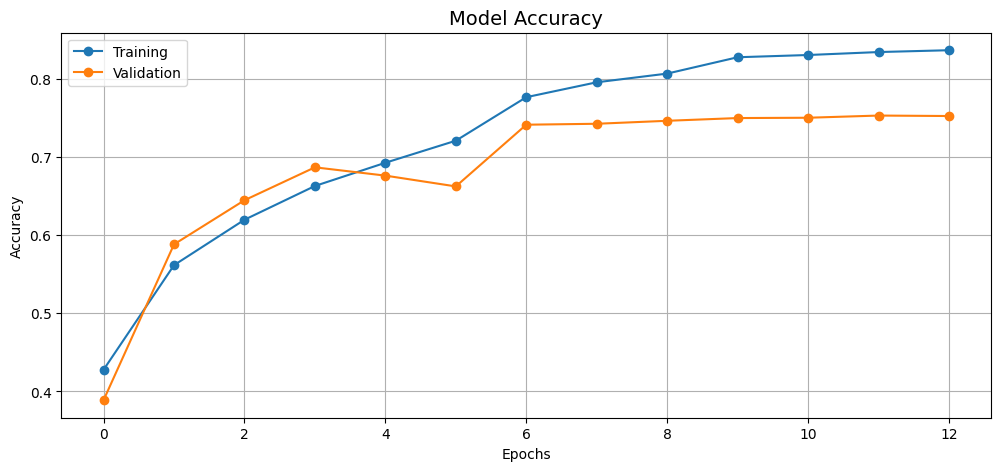

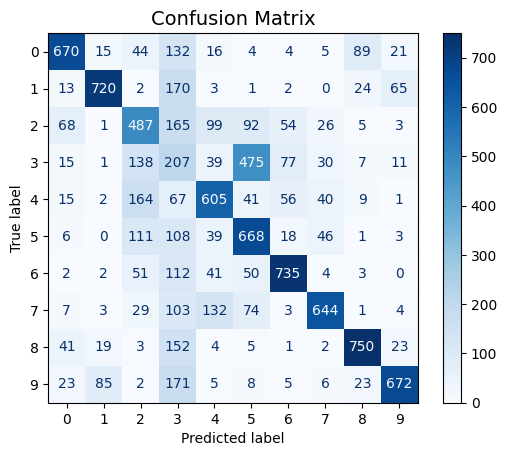

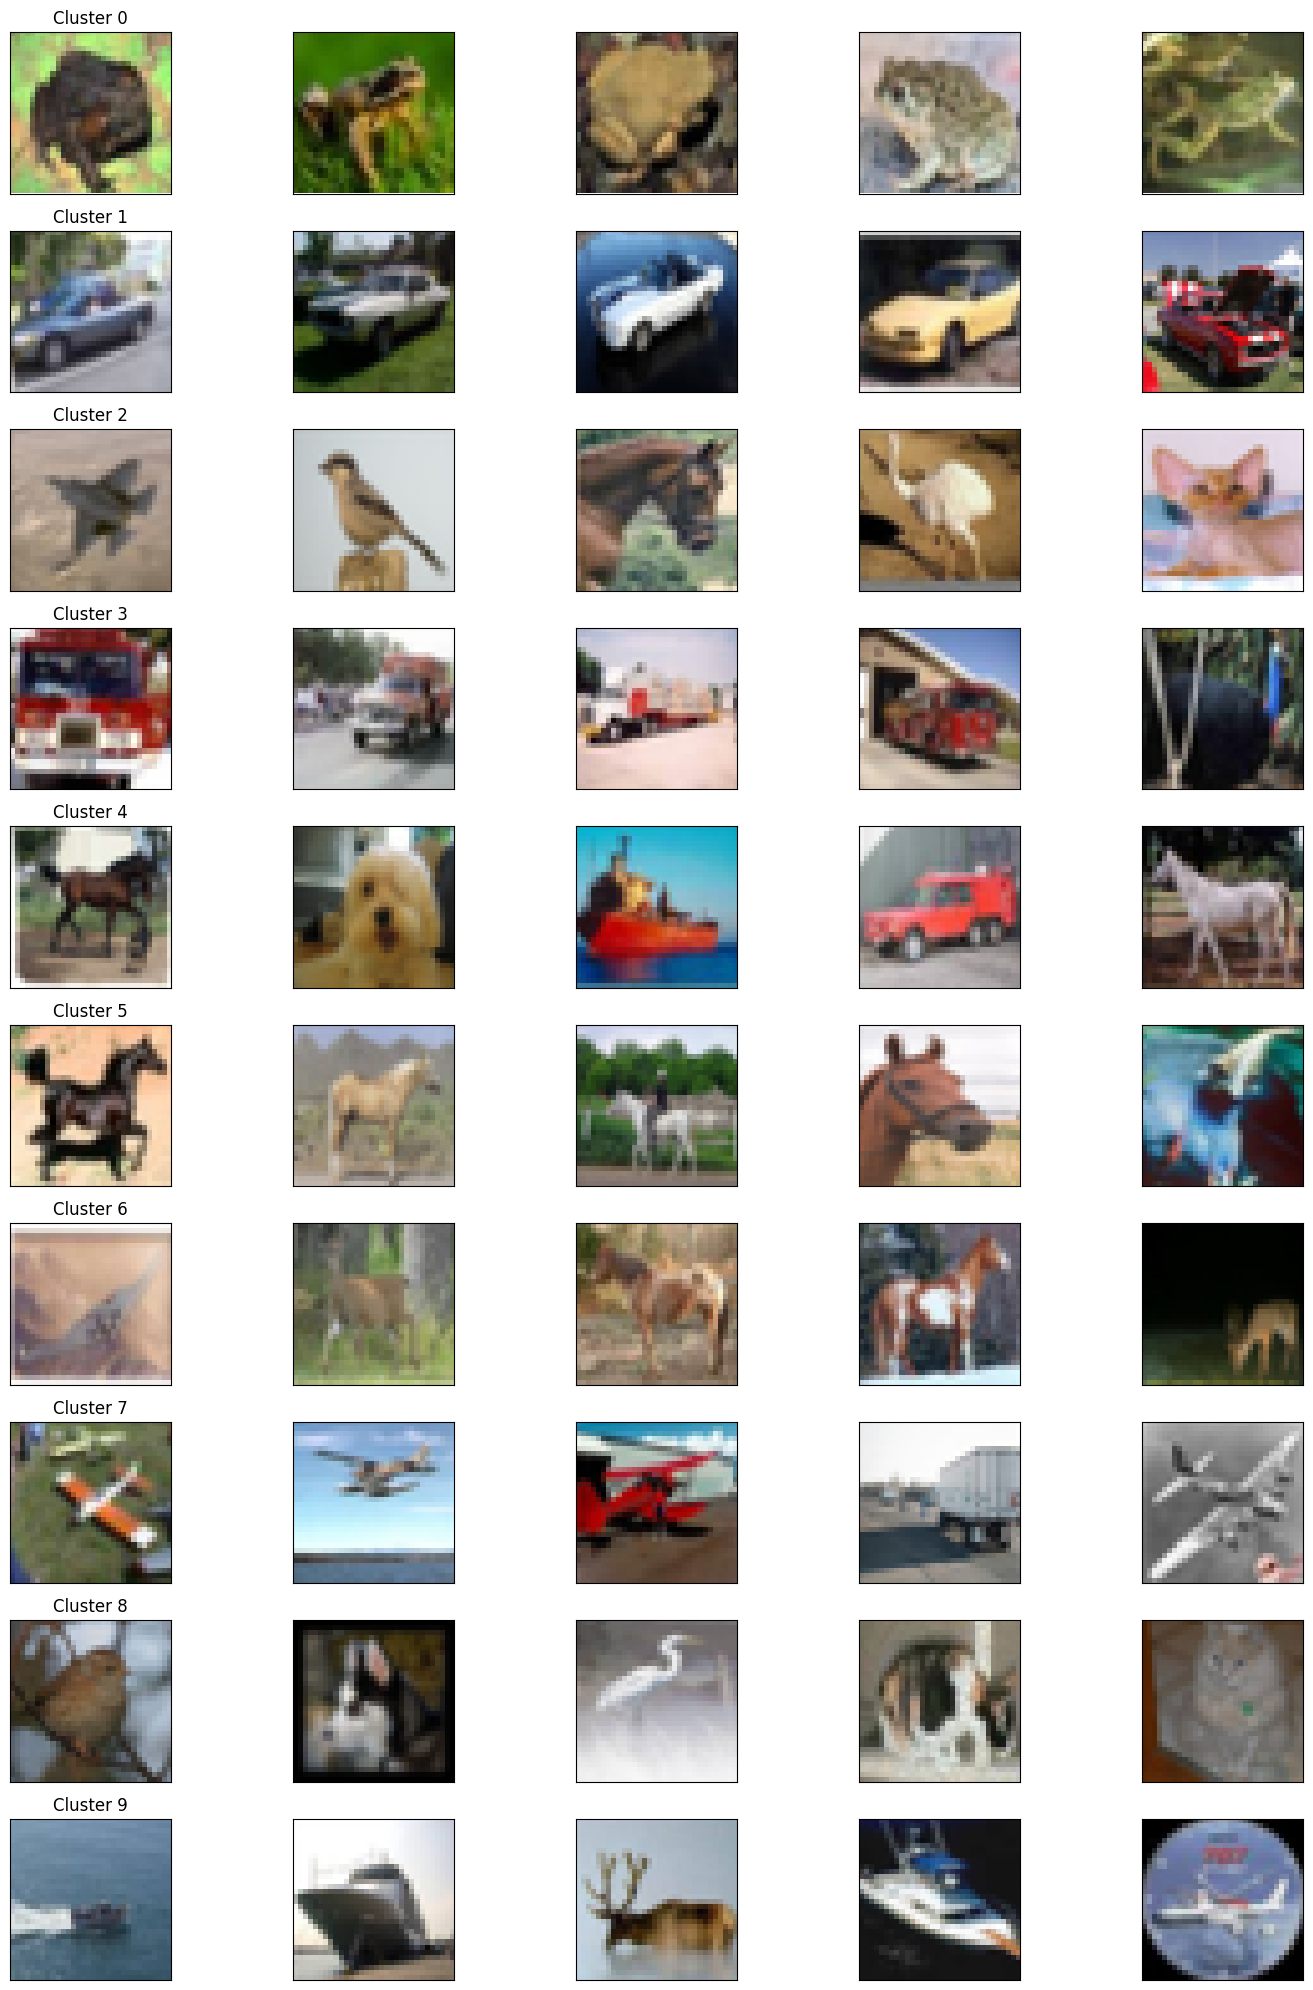

In [6]:

# Function to map GMM clusters to actual CIFAR-10 labels
def map_gmm_to_labels(gmm_preds, y_true):
    labels = np.zeros_like(gmm_preds)
    for i in range(10):  # 10 clusters
        mask = gmm_preds == i
        if np.sum(mask) > 0:  # Avoid empty clusters
            labels[mask] = mode(y_true[mask], keepdims=True)[0][0]
    return labels.astype(int)  # Ensure integer labels


# Function to visualize clusters with sample images
def visualize_cluster_grid(x_test, gmm_preds, num_clusters=10, samples_per_cluster=5):
    fig, axes = plt.subplots(num_clusters, samples_per_cluster, figsize=(15, 20))

    for cluster in range(num_clusters):
        cluster_indices = np.where(gmm_preds == cluster)[0]

        if len(cluster_indices) == 0:
            for idx in range(samples_per_cluster):
                axes[cluster, idx].axis("off")  # Hide empty clusters
            continue

        sample_indices = np.random.choice(
            cluster_indices,
            min(samples_per_cluster, len(cluster_indices)),
            replace=False,
        )

        for idx in range(samples_per_cluster):
            ax = axes[cluster, idx]
            if idx < len(sample_indices):
                ax.imshow(x_test[sample_indices[idx]])
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis("off")  # Hide empty spots

            if idx == 0:
                ax.set_title(f"Cluster {cluster}", fontsize=12)

    plt.tight_layout()
    plt.savefig("cluster_grid.png", bbox_inches="tight", dpi=300)
    plt.show()


# Map clusters to labels
gmm_labels = map_gmm_to_labels(gmm_preds, y_test)

# Compute accuracy safely
accuracy = np.mean(gmm_labels == y_test.flatten())
print(f"GMM Classification Accuracy: {accuracy * 100:.2f}%")

# Pick a random test image
index = np.random.randint(0, len(x_test))
test_image = x_test[index]

# Extract features, reduce with PCA, and predict with GMM
test_feature = feature_extractor.predict(test_image.reshape(1, 32, 32, 3))
test_pca = pca.transform(test_feature)
pred_cluster = gmm.predict(test_pca)[0]  # Ensure single value output

# Visualize results
plt.figure(figsize=(12, 5))

# Plot training history

plt.plot(history.history["accuracy"], label="Training", marker="o")
plt.plot(history.history["val_accuracy"], label="Validation", marker="o")
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()


cm = confusion_matrix(y_test.flatten(), gmm_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix", fontsize=14)


plt.show()

# Show the cluster visualization grid
visualize_cluster_grid(x_test, gmm_preds)
